In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
from wordcloud import WordCloud
#nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/byronsun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('../Data/twitter_clean.csv')
df = df.drop(df.keys()[0], axis=1)
df = df.dropna(subset=['cleaned_text'])
l_multi_lan = len(df)
df.head()

,author_id,cleaned_text,sentiment,gcc,left,bottom,right,top,Language,Greater Capital City
0,3103790508,sorry|you|were|subjected|this,-0.100000,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper
1,1139092998,naww,0.000000,perth,115.617614,-32.675715,116.239023,-31.624486,tl,5gper
2,269765480,interesting|how|much|actual|traffic|would|you|...,0.137931,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper
3,1214733954319704064,appreciate|the|love|especially|only|available|...,0.357143,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper
4,160863117,won|has|already|been|overshadowed|deaths|and|h...,-0.269231,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper


In [33]:
df = df.loc[df['Language']=='en']
l_en_lan = len(df)
print(l_en_lan/l_multi_lan)

In [32]:
l_en_lan/l_multi_lan

0.9011896443208793

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if o

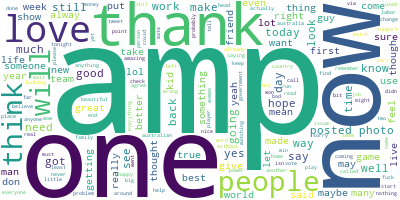

In [36]:
# Join the different processed titles together.
long_string = ','.join(list(df['cleaned_text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [37]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df.cleaned_text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
#print(data_words[:2])

/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/opt/anaconda3/lib/python3.9/site-packages/word

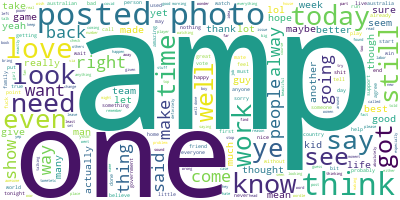

In [38]:
long_string = ', '.join([item for sublist in data_words for item in sublist])
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [39]:
data_lemmatized = [' '.join(sublist) for sublist in data_words]
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=100)
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [40]:
# Build LDA Model
import time
%time
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.15 µs
LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)


In [41]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -13306874.97978209
Perplexity:  107.57597276688705
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [ ]:
# # Define Search Param
# search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# # Init the Model
# lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params)
# # Do the Grid Search
# # model.fit(data_vectorized)
# GridSearchCV(cv=None, error_score='raise',
#        estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
#              evaluate_every=-1, learning_decay=0.7, learning_method=None,
#              learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
#              mean_change_tol=0.001, n_components=10, n_jobs=1,
#              n_topics=None, perp_tol=0.1, random_state=None,
#              topic_word_prior=None, total_samples=1000000.0, verbose=0),
#        fit_params=None, iid=True, n_jobs=1,
#        param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
#        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#        scoring=None, verbose=0)

# # Best Model
# best_lda_model = model.best_estimator_
# # Model Parameters
# print("Best Model's Params: ", model.best_params_)
# # Log Likelihood Score
# print("Best Log Likelihood Score: ", model.best_score_)
# # Perplexity
# print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

In [42]:
best_lda_model = lda_model

In [43]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
#df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0
Doc1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,9
Doc2,0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0
Doc3,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,6
Doc4,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0
...,...,...,...,...,...,...,...,...,...,...,...
Doc2182132,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0
Doc2182133,0.03,0.03,0.03,0.03,0.37,0.03,0.03,0.03,0.03,0.37,4
Doc2182134,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0
Doc2182135,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,5


In [44]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,actually,amazing,amp,australia,australian,away,bad,beautiful,best,better,...,way,week,win,women,work,world,yeah,year,years,yes
Topic0,0.100007,0.100005,0.100005,0.100003,0.100005,0.100004,0.100006,0.100003,0.100003,0.100008,...,0.100008,0.100004,0.100003,0.100003,0.100009,0.100005,0.100005,0.100006,0.100004,40657.050245
Topic1,0.100008,0.100004,0.100006,0.100003,0.100009,0.100006,0.100007,0.100001,0.100003,0.100008,...,0.100008,25133.606038,0.100005,0.100004,0.100009,0.100005,0.100006,0.100008,0.100004,0.100004
Topic2,0.100008,0.100005,0.100005,29125.070542,0.100008,16306.034497,0.100006,0.100003,0.100003,0.100008,...,0.100008,0.100005,0.100003,15051.601046,0.100007,0.100006,0.100005,0.100007,0.100004,0.100004
Topic3,15541.315482,0.100004,0.100005,0.100011,18135.504489,0.100004,0.100006,0.100003,0.100003,29749.794119,...,34903.038078,0.100004,0.100004,0.100004,0.100006,0.100006,0.100004,24498.111183,0.100004,0.100003
Topic4,0.100007,0.100006,107761.887115,0.100005,0.100010,0.100006,0.100008,0.100003,0.100004,0.100008,...,0.100009,0.100006,0.100005,0.100006,0.100009,25443.710144,22091.962973,0.100008,0.100005,0.100003
Topic5,0.100009,0.100004,0.100005,0.100003,0.100007,0.100005,15602.891689,0.100006,0.100003,0.100007,...,0.100008,0.100005,0.100003,0.100004,36518.651059,0.100005,0.100006,0.100007,0.100004,0.100004
Topic6,0.100009,0.100005,0.100006,0.100003,0.100009,0.100005,0.100008,0.100003,0.100003,0.100009,...,0.100008,0.100003,0.100002,0.100004,0.100008,0.100008,0.100004,0.100006,0.100004,0.100004
Topic7,0.100006,0.100004,0.100005,0.100003,0.100006,0.100005,0.100006,23560.241016,29391.803141,0.100007,...,0.100008,0.100004,0.100003,0.100004,0.100007,0.100006,0.100005,0.100007,0.100004,0.100004
Topic8,0.100008,0.100005,0.100006,0.100004,0.100008,0.100006,0.100007,0.100002,0.100004,0.100007,...,0.100008,0.100005,15361.993189,0.100004,0.100007,0.100007,0.100004,0.100009,35538.943384,0.100003
Topic9,0.100009,15618.561913,0.100006,0.100004,0.100011,0.100005,0.100007,0.100005,0.100004,0.100009,...,0.100009,0.100005,0.100004,0.100005,0.100009,0.100005,0.100004,0.100007,0.100005,0.100004


In [47]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,love,yes,make,sure,come,said,night,hard,looks,job,look,like,work,way,better
Topic 1,right,want,week,getting,mate,nice,election,maybe,money,covid,start,support,look,change,help
Topic 2,think,thanks,australia,home,little,looking,things,away,women,tonight,look,family,big,country,way
Topic 3,photo,today,posted,way,better,hope,year,big,look,thing,old,help,lol,australian,country
Topic 4,amp,great,new,really,world,game,yeah,real,family,look,help,country,change,australian,big
Topic 5,like,good,time,know,work,morning,bad,family,look,looks,thing,hope,actually,day,old
Topic 6,people,thank,man,feel,lot,free,end,country,help,like,better,actually,australian,family,look
Topic 7,need,got,best,let,beautiful,true,help,know,look,hope,thing,country,change,today,way
Topic 8,going,years,happy,live,thought,team,stop,win,person,old,country,year,today,end,look
Topic 9,day,say,life,long,government,labor,bit,days,care,amazing,vote,read,end,change,today


In [48]:
Topics = ["1","2","3","4","5", "6 ", "7", "8", "9", "10"]#, 'a','b','c','d','e','f','g','h','i','j'
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,love,yes,make,sure,come,said,night,hard,looks,job,look,like,work,way,better,1
Topic 1,right,want,week,getting,mate,nice,election,maybe,money,covid,start,support,look,change,help,2
Topic 2,think,thanks,australia,home,little,looking,things,away,women,tonight,look,family,big,country,way,3
Topic 3,photo,today,posted,way,better,hope,year,big,look,thing,old,help,lol,australian,country,4
Topic 4,amp,great,new,really,world,game,yeah,real,family,look,help,country,change,australian,big,5
Topic 5,like,good,time,know,work,morning,bad,family,look,looks,thing,hope,actually,day,old,6
Topic 6,people,thank,man,feel,lot,free,end,country,help,like,better,actually,australian,family,look,7
Topic 7,need,got,best,let,beautiful,true,help,know,look,hope,thing,country,change,today,way,8
Topic 8,going,years,happy,live,thought,team,stop,win,person,old,country,year,today,end,look,9
Topic 9,day,say,life,long,government,labor,bit,days,care,amazing,vote,read,end,change,today,10


In [49]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [50]:
# Define function to predict topic for a given text document.
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
# Predict the topic
mytext = ["Very Useful in diabetes age 30. I need control sugar. thanks Good deal"]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

['got', 'best', 'let', 'beautiful', 'true', 'help', 'know', 'look', 'hope', 'thing', 'country', 'change', 'today']
8


In [51]:
def apply_predict_topic(text):
    text = [text]
    infer_topic, topic, prob_scores = predict_topic(text = text)
    return(infer_topic)
df["Topic_key_word"]= df['cleaned_text'].apply(apply_predict_topic)
df

,author_id,cleaned_text,sentiment,gcc,left,bottom,right,top,Language,Greater Capital City,Topic_key_word
0,3103790508,sorry|you|were|subjected|this,-0.100000,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper,1
2,269765480,interesting|how|much|actual|traffic|would|you|...,0.137931,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper,10
3,1214733954319704064,appreciate|the|love|especially|only|available|...,0.357143,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper,1
4,160863117,won|has|already|been|overshadowed|deaths|and|h...,-0.269231,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper,7
5,1274596050292977664,woof,0.000000,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper,1
...,...,...,...,...,...,...,...,...,...,...,...
2421388,1951324189,first|one|was|disaster|damaged|tendon|and|had|...,-0.050000,carmoo,146.020583,-17.959584,146.064858,-17.936171,en,3rqld,1
2421392,96417014,amp|stopping|for|the|day|current|location|find...,-0.052632,madura,126.300790,-32.311595,127.725424,-31.380004,en,5rwau,10
2421393,96417014,starting|from|current|location|now|find|with|i...,0.000000,madura,126.300790,-32.311595,127.725424,-31.380004,en,5rwau,2
2421395,1551885763771772929,thankyou|ice|for|sharing|you|career|with|your|...,0.083333,magill,138.665950,-34.919632,138.685203,-34.896629,en,4gade,1


In [53]:
df['Topic_key_word'].value_counts()

Topic_key_word
1     960771
4     203728
6     190024
7     169286
10    154587
2     129700
5     112367
8      95153
3      83377
9      83144
Name: count, dtype: int64

In [52]:
df.groupby('Topic_key_word').nunique()

,author_id,cleaned_text,sentiment,gcc,left,bottom,right,top,Language,Greater Capital City
Topic_key_word,,,,,,,,,,
1,33967,786571,1696,3162,3547,3550,3545,3550,1,16
10,17479,144961,1401,1520,1640,1640,1639,1640,1,16
2,15413,122033,1249,1121,1180,1180,1178,1180,1,16
3,12702,80246,1074,1000,1041,1041,1041,1041,1,16
4,21753,170355,1359,2027,2190,2191,2189,2191,1,16
5,16090,104309,1353,1269,1343,1343,1341,1343,1,16
6,18850,173084,1505,1442,1546,1546,1544,1546,1,16
7,17422,146285,1507,1180,1235,1235,1234,1235,1,15
8,13505,83661,1220,977,1017,1017,1016,1017,1,16


In [54]:
df.to_csv('../Data/googlePlayStore_review_LDA.csv')

In [55]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.31  0.3   0.3   0.41  0.32  0.39  0.26  0.27  0.27  0.3 ]
 [-0.12 -0.07 -0.04  0.86 -0.09 -0.48 -0.05 -0.05 -0.05 -0.07]]
Perc of Variance Explained: 
 [0.   0.19]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

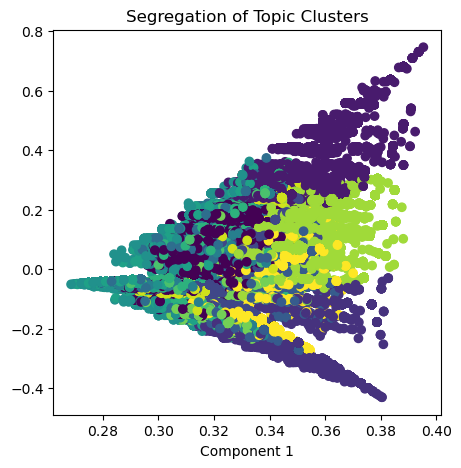

In [58]:
# Plot
plt.figure(figsize=(5, 5))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )